In [1]:
import numpy as np
import h5py
import string
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Meta data of papers
class PaperMeta(object):
    def __init__(self, title, abstract, keyword, rating):
        self.title = title  # str
        self.abstract = abstract  # str
        self.keyword = keyword  # list[str]
        self.rating = rating  # list[int]
        
        if len(self.rating) > 0:
            self.average_rating = np.mean(rating)
        else:
            self.average_rating = -1

            
class Keyword(object):
    def __init__(self, keyword, frequency, rating):
        self.keyword = keyword  # list[str]
        self.frequency = frequency
        self.rating = rating  # list[int]        
    
    def average_rating(self):
        if len(self.rating) > 0:
            return np.mean(self.rating)
        else:
            return -1
    
    def update_frequency(self, frequency):
        self.frequency += frequency
        
    def update_rating(self, rating):
        self.rating = np.concatenate((self.rating, rating))
            
            
def write_meta(meta_list, filename):
    f = h5py.File(filename, 'w')
    for i, m in enumerate(meta_list):
        grp = f.create_group(str(i))
        grp['title'] = m.title
        grp['abstract'] = m.abstract
        grp['keyword'] = '#'.join(m.keyword)
        grp['rating'] = m.rating
    f.close()
    
    
def read_meta(filename):
    f = h5py.File(filename, 'r')
    meta_list = []
    for k in list(f.keys()):
        meta_list.append(PaperMeta(
            f[k]['title'].value, 
            f[k]['abstract'].value, 
            f[k]['keyword'].value.split('#'),
            f[k]['rating'].value
        ))
    return meta_list


def crawl_meta(meta_hdf5=None, write_meta_name='data.hdf5'):
    
    if meta_hdf5 is None:
        # Crawl the meta data from OpenReview
        # Set up a browser to crawl from dynamic web pages 
        from selenium import webdriver
        from selenium.webdriver.chrome.options import Options
        import time
        executable_path = '/Users/waltersun/Desktop/chromedriver'
        options = Options()
        options.add_argument("--headless")
        browser = webdriver.Chrome(options=options, executable_path=executable_path)            
    
        # Load all URLs for all ICLR submissions
        urls = []
        with open('urls.txt') as f:
            urls = f.readlines()
        urls = [url.strip() for url in urls]
    
        meta_list = [] 
        fail_list = []
        wait_time = 2
        max_try = 100
        for i, url in enumerate(urls):
            try:
                browser.get(url)
                time.sleep(wait_time)
                key = browser.find_elements_by_class_name("note_content_field")
                key = [k.text for k in key]
                value = browser.find_elements_by_class_name("note_content_value")
                value = [v.text for v in value]
                # title
                title = string.capwords(browser.find_element_by_class_name("note_content_title").text)
                # abstract
                valid = False
                tries = 0
                while not valid:
                    if 'Abstract:' in key:
                        valid = True
                    else:
                        time.sleep(wait_time)
                        tries += 1
                        if tries >= max_try:
                            print('Reached max try: {} ({})'.format(title, url))
                            break
                abstract = ' '.join(value[key.index('Abstract:')].split('\n'))
                # keyword
                if 'Keywords:' in key:
                    keyword = value[key.index('Keywords:')].split(',')
                    keyword = [k.strip(' ') for k in keyword]
                    keyword = [''.join(string.capwords(k).split(' ')) for k in keyword if not k == '']
                    for j in range(len(keyword)):
                        if '-' in keyword[j]:
                            keyword[j] = ''.join([string.capwords(kk) for kk in keyword[j].split('-')])       
                else:
                    keyword = []
                # rating
                rating_idx = [i for i, x in enumerate(key) if x == "Rating:"]
                rating = []
                if len(rating_idx) > 0:
                    for idx in rating_idx:
                        rating.append(int(value[idx].split(":")[0]))
                print('[{}] [Abs: {} chars, keywords: {}, ratings: {}] {}'.format(
                    i, len(abstract), len(keyword), rating, title))
                meta_list.append(PaperMeta(title, abstract, keyword, rating))
            except:
                print('Failed to load {}'.format(url))
            
        # Save the crawled data
        write_meta(meta_list, write_meta_name)
    else:
        # Load the meta data from local
        meta_list = read_meta(meta_hdf5)
        fail_list = []
    return meta_list, fail_list

In [3]:
# Get the meta data
# Load the data file
meta_list, _ = crawl_meta('data.hdf5')
# Crawl data from scratch
# meta_list, fail_list = crawl_meta()
print('Number of submissions: {}'.format(len(meta_list)))

Number of submissions: 1572


In [4]:
rating = []
rating_mean = []
num_rating = []
keywords = []
for m in meta_list:
    rating.extend(m.rating)
    keywords.extend(m.keyword)
    num_rating.append(len(m.rating))
    if len(m.rating) > 0:
        rating_mean.append(m.average_rating)
print('Average rating: {}'.format(np.mean(rating)))

Average rating: 5.143274197170447


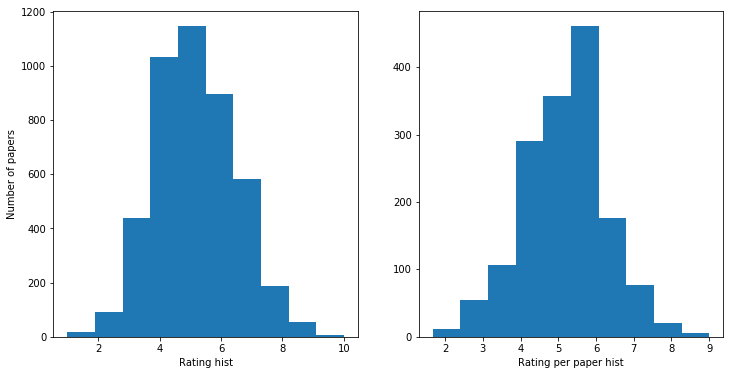

In [5]:
# Plot histograms of ratings
fig = plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.hist(rating, bins=10)
plt.xlabel('Rating hist')
plt.ylabel('Number of papers')
plt.subplot(122)
plt.hist(rating_mean, bins=10)
plt.xlabel('Rating per paper hist')
plt.show()

In [6]:
# See how many papers are beaten by yours
def PR(rating_mean, your_rating):
    pr = np.sum(your_rating >= np.array(rating_mean))/len(rating_mean)*100
    return pr
my_rating = (5+6+7)/3  # your average rating here
print('Your papar beats {:.2f}% of submission '
      '(well, jsut based on the ratings...)'.format(PR(rating_mean, my_rating)))


# ICLR 2017: accept rate 39.1% (198/507) (15 orals and 183 posters)
# ICLR 2018: accept rate 32% (314/981) (23 orals and 291 posters)
# ICLR 2018: accept rate ?% (?/1580)

Your papar beats 82.16% of submission (well, jsut based on the ratings...)


In [7]:
# Count keywords
from collections import Counter
keywords_hist = Counter(keywords)
del keywords_hist['']
print('{} different keywords before merging'.format(len(keywords_hist)))

# Merge duplicates: CNNs and CNN
duplicates = []
for k in keywords_hist:
    if k+'s' in keywords_hist:
        duplicates.append(k)
for k in duplicates:
    keywords_hist[k] += keywords_hist[k+'s']
    del keywords_hist[k+'s']
# print('Merge: {}'.format([d+'s' for d in duplicates]))
print('{} different keywords after merging'.format(len(keywords_hist)))

2854 different keywords before merging
2752 different keywords after merging


In [8]:
# Create keywords list
keywords_list = []
keywords_key_list = []
for m in meta_list:
    for k in [mk for mk in m.keyword if not mk == '']:
        if k not in keywords_hist.keys():
            k = k[:-1]  # strip 's'
        if k in keywords_key_list:
            idx = keywords_key_list.index(k)
            keywords_list[idx].update_frequency(1)
            keywords_list[idx].update_rating(m.rating)
        else:
            # the keyword is new to the list
            k_object = Keyword(k, 1, m.rating)
            keywords_list.append(k_object)
            keywords_key_list.append(k_object.keyword)

66


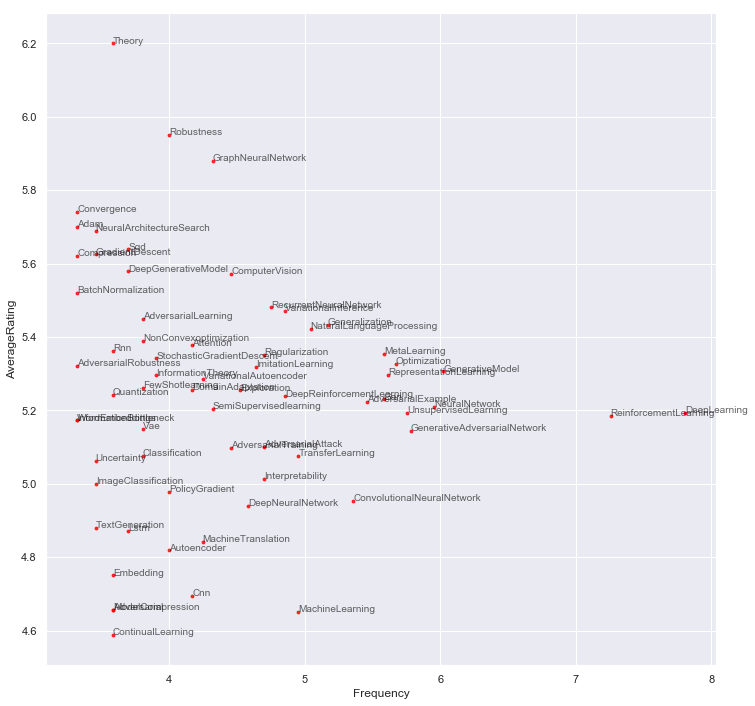

In [9]:
keywords_list_subset = [k for k in keywords_list if k.frequency > 9]
print(len(keywords_list_subset))
y = [k.average_rating() for k in keywords_list_subset]
x = [np.log2(k.frequency) for k in keywords_list_subset]
key = [k.keyword for k in keywords_list_subset]

# Create dataframe
df = pd.DataFrame({
'Frequency': x,
'AverageRating': y,
'Keyword': key
})

sns.set(font_scale=1)
fig = plt.figure(figsize=(12, 12))
p1 = sns.regplot(data=df, x="Frequency", y="AverageRating", fit_reg=False, 
                 marker="o", color="red", logx=True, scatter_kws={'s': 8})
for line in range(0, df.shape[0]):
     p1.text(df.Frequency[line], df.AverageRating[line], df.Keyword[line], 
             horizontalalignment='left', 
             size='small', color='black', alpha=0.6)
plt.show()

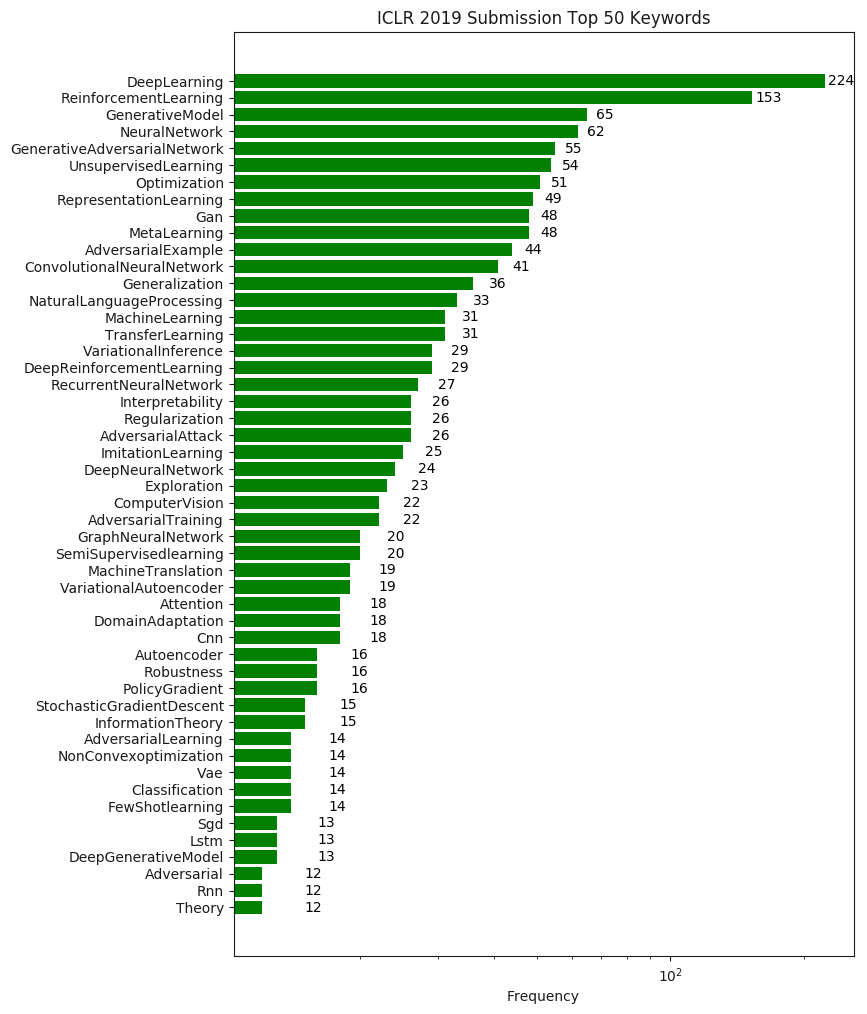

In [10]:
# Show N most common keywords and their frequencies
num_keyowrd = 50
keywords_hist_vis = keywords_hist.most_common(num_keyowrd)

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(8, 12))

key = [k[0] for k in keywords_hist_vis] 
value = [k[1] for k in keywords_hist_vis] 
y_pos = np.arange(len(key))
ax.barh(y_pos, value, align='center', color='green', ecolor='black', log=True)
ax.set_yticks(y_pos)
ax.set_yticklabels(key, rotation=0, fontsize=10)
ax.invert_yaxis() 
for i, v in enumerate(value):
    ax.text(v + 3, i + .25, str(v), color='black', fontsize=10)
# ax.text(y_pos, value, str(value))
ax.set_xlabel('Frequency')
ax.set_title('ICLR 2019 Submission Top {} Keywords'.format(num_keyowrd))

plt.show()

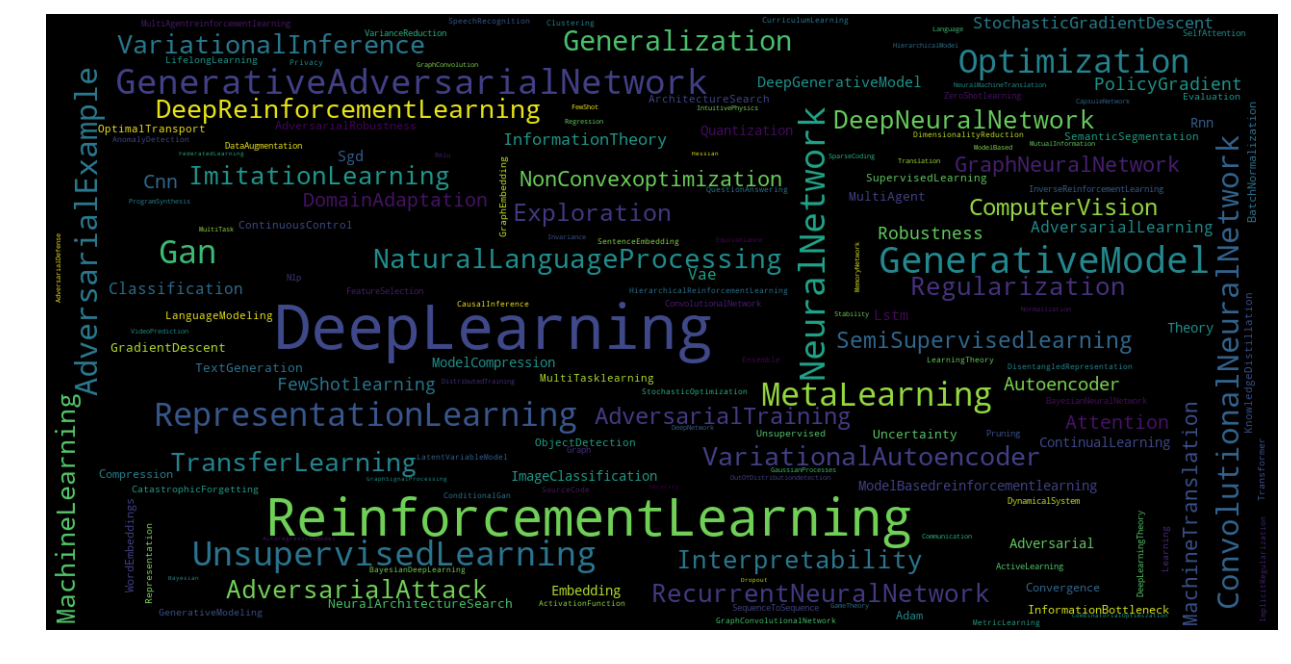

In [11]:
# Show the word cloud forming by keywords
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=64, max_words=160, 
                      width=1280, height=640,
                      background_color="black").generate(' '.join(keywords))
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

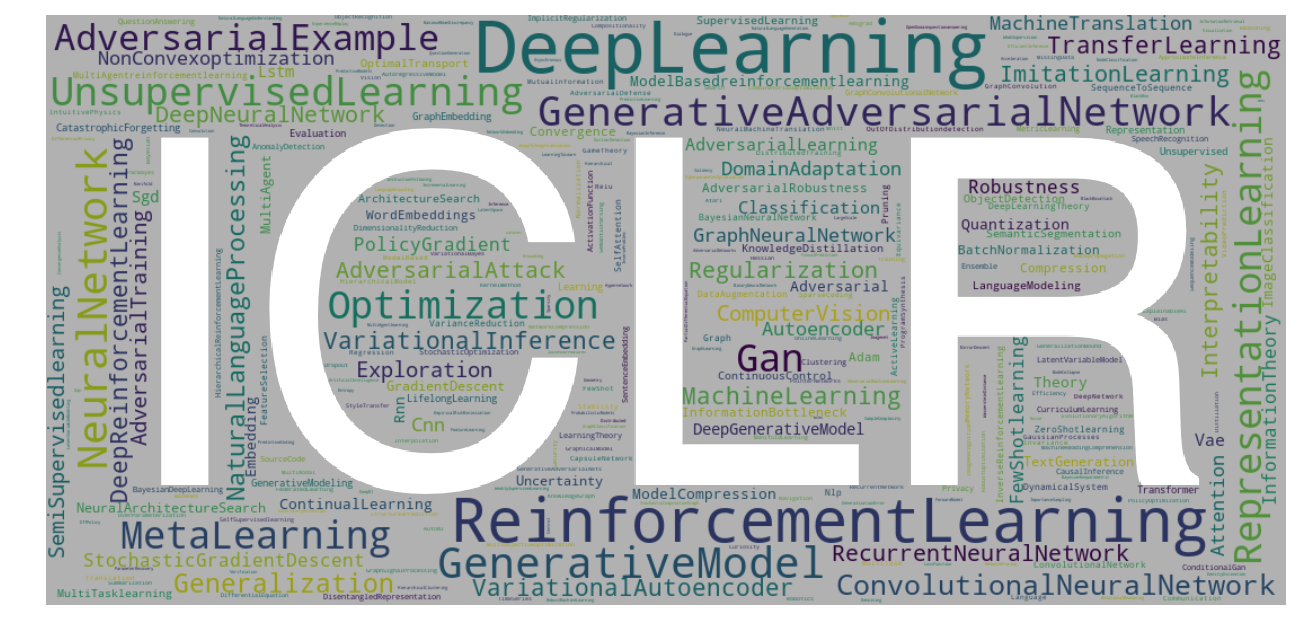

In [12]:
# Show the word cloud with an ICLR logo
from imageio import imread
logo = imread('logo.png')
wordcloud = WordCloud(max_font_size=64, max_words=300, 
                      width=1280, height=640,
                      background_color="white", mask=logo).generate(' '.join(keywords))
plt.figure(figsize=(16, 8), frameon=False)
plt.imshow(logo)
plt.imshow(wordcloud, interpolation="bilinear",  alpha=.7)
plt.axis("off")
plt.show()

In [13]:
missing_rating = np.sum(3-np.clip(num_rating, 0, 3))
print('Number of missing reviews: {} ({:.4f}%)'.format(
    missing_rating, 100*float(missing_rating)/(len(meta_list)*3)))

Number of missing reviews: 275 (5.8312%)
